# Evaluation of CyteType

CyteType is a tool for automatic curation of cell types in single cell, using an LLM Annotator Agent.

In this notebook, we try the tool on a few datasets and compare it with other annotation tools.

### Install Libraries

In [1]:
!python -m pip install -q cytetype scanpy igraph leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 4.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ydata-profiling 4.16.1 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.3 which is incompat

In [2]:
import anndata
import scanpy as sc
import cytetype
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Initialize Paul15 dataset

The Paul et al 2015 dataset is a small single-cell dataset of myeloid cells, available from scanpy. The Cell types have been manually annotated, meaning we can compare cytetype's predictions against the true values.

In [3]:
#adata = sc.datasets.paul15()


In [4]:
import os
import scanpy as sc

if not os.path.exists("paul15_small.h5ad"):
    adata = sc.datasets.paul15()
    adata.write("paul15_small.h5ad")
else:
    adata = sc.read("paul15_small.h5ad")


  0%|          | 0.00/9.82M [00:00<?, ?B/s]

... storing 'paul15_clusters' as categorical


### Process the data - compute clusters, etc

In [5]:
adata.obs["paul15_clusters"]

W31105      7MEP
W31106      15Mo
W31107      3Ery
W31108      15Mo
W31109      3Ery
           ...  
W39164      2Ery
W39165    13Baso
W39166      7MEP
W39167      15Mo
W39168      3Ery
Name: paul15_clusters, Length: 2730, dtype: category
Categories (19, object): ['1Ery', '2Ery', '3Ery', '4Ery', ..., '16Neu', '17Neu', '18Eos', '19Lymph']

In [6]:

# Load and preprocess your data
adata.var["gene_symbols"] = adata.var_names

# We compute the clusters as suggested by the tutorial
# However, this produces 10 clusters. We are going to use the 19
# clusters from the original paper, which are stored in the `paul15_clusters` column.
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.rank_genes_groups(adata, groupby='paul15_clusters', method='t-test')

# Initialize CyteType (performs data preparation)
annotator = cytetype.CyteType(
    adata,
    group_key='paul15_clusters',           # Required: cluster column name
    rank_key='rank_genes_groups',          # DE results key (default)
    gene_symbols_column='gene_symbols',    # Gene symbols column (default)
    n_top_genes=50,                        # Top marker genes per cluster
    #results_prefix='cytetype'              # Prefix for result columns
)

2025-07-17 13:50:54.250361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752760254.576169      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752760254.662181      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_13/798197818.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


Using coordinates from 'X_pca' for visualization.
Calculating expression percentages.
Extracting marker genes.
Preparing visualization data with sampling.
Using first 2 dimensions of 'X_pca' for visualization.
Extracted 2730 coordinate points (sampled from 2730 total cells)
Data preparation completed. Ready for submitting jobs.


In [7]:
adata.obs

,paul15_clusters,leiden
W31105,7MEP,6
W31106,15Mo,7
W31107,3Ery,1
W31108,15Mo,3
W31109,3Ery,1
...,...,...
W39164,2Ery,0
W39165,13Baso,4
W39166,7MEP,6
W39167,15Mo,3


In [8]:
# How many clusters are there?
print(f"Number of clusters: {len(adata.obs['paul15_clusters'].unique())}")
adata.obs['paul15_clusters'].value_counts().sort_index()


Number of clusters: 19


paul15_clusters
1Ery        43
2Ery       329
3Ery       246
4Ery       124
5Ery       180
6Ery       173
7MEP       167
8Mk         68
9GMP        63
10GMP      153
11DC        30
12Baso      69
13Baso     300
14Mo       373
15Mo       186
16Neu      164
17Neu       22
18Eos        9
19Lymph     31
Name: count, dtype: int64

In [9]:
# Cluster annotation from original paper
adata.obs


,paul15_clusters,leiden
W31105,7MEP,6
W31106,15Mo,7
W31107,3Ery,1
W31108,15Mo,3
W31109,3Ery,1
...,...,...
W39164,2Ery,0
W39165,13Baso,4
W39166,7MEP,6
W39167,15Mo,3


### Call the Agent! Run the annotation

In [10]:
# Run annotation
adata = annotator.run(
    study_context="""
    Mouse bone marrow cells undergoing myeloid differentiation. This includes several subtypes of immune cell progenitors.

    """
)

# View results
#print(adata.obs.cytetype_leiden)

CyteType job (id: e1c92fec-6b04-4fa0-8e28-d865712d7754) submitted. Polling for results...
Report (updates automatically) available at: https://nygen-labs-prod--cytetype-api.modal.run/report/e1c92fec-6b04-4fa0-8e28-d865712d7754
If network disconnects, the results can be fetched like this:
`results = annotator.get_results()`
250717:1351:31 |INFO| [STARTING WORKFLOWS]: Job ID: e1c92fec-6b04-4fa0-8e28-d865712d7754
250717:1351:31 |INFO| [WORKFLOW STEP 1/3]: Generating context summary
250717:1351:44 |INFO| [WORKFLOW STEP 2/3]: Running annotation pipeline for each cluster
250717:1352:51 |SUCCESS| [Cluster: 2] Annotation completed in 58.55s after 1 attempt(s) and 63348 tokens used
250717:1352:54 |SUCCESS| [Cluster: 3] Annotation completed in 60.11s after 1 attempt(s) and 68443 tokens used
250717:1353:01 |SUCCESS| [Cluster: 4] Annotation completed in 58.65s after 1 attempt(s) and 60660 tokens used
250717:1353:31 |SUCCESS| [Cluster: 1] Annotation completed in 77.77s after 2 attempt(s) and 104898

### Compare annotation with existing one

The original annotation are more granular than the ones from Cytetype, so we manually create a dictionary to make a comparison.

In [11]:
print(adata.obs)

       paul15_clusters leiden    cytetype_annotation_paul15_clusters  \
W31105            7MEP      6       Myeloid Progenitor Cell (GATA2+)   
W31106            15Mo      7         Neutrophil Progenitor (Elane+)   
W31107            3Ery      1  Erythroid Progenitor (heme synthesis)   
W31108            15Mo      3         Neutrophil Progenitor (Elane+)   
W31109            3Ery      1  Erythroid Progenitor (heme synthesis)   
...                ...    ...                                    ...   
W39164            2Ery      0          Erythroid Progenitor (Ermap+)   
W39165          13Baso      4       Myeloid Progenitor Cell (Prtn3+)   
W39166            7MEP      6       Myeloid Progenitor Cell (GATA2+)   
W39167            15Mo      3         Neutrophil Progenitor (Elane+)   
W39168            3Ery      1  Erythroid Progenitor (heme synthesis)   

       cytetype_cellOntologyTerm_paul15_clusters  
W31105                                CL_0000839  
W31106                           

In [12]:
print(adata.obs.cytetype_annotation_paul15_clusters.unique().to_list())

['Myeloid Progenitor Cell (GATA2+)', 'Neutrophil Progenitor (Elane+)', 'Erythroid Progenitor (heme synthesis)', 'Erythroid Progenitor (Car2+)', 'Erythroid Progenitor (Ermap+)', 'Granulocyte-Monocyte Progenitor (stress-activated)', 'Neutrophil Progenitor (Prtn3+)', 'Myeloid Progenitor Cell (Prtn3+)', 'Megakaryocyte Progenitor', 'Myeloid Progenitor Cell (GPR56+)', 'Early Myeloid Progenitor', 'Neutrophil Progenitor (early)', 'Early Erythroid Progenitor with Megakaryocytic Potential', 'Erythroid Progenitor (Hba-a2+)', 'Erythroid Progenitor (ribosomal)', 'Stress-responsive Hematopoietic Progenitor', 'Transitioning Myeloid Progenitor', 'Granulocyte Progenitor (Cebpe+)', 'Myeloid Progenitor Cell (Cd74+)']


/tmp/ipykernel_13/2255399537.py:1: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  print(adata.obs.cytetype_annotation_paul15_clusters.unique().to_list())


In [13]:
label_map = {
    '1Ery': 'Erythroblast',
    '2Ery': 'Erythroid precursor',
    '3Ery': 'Erythroblast',
    '4Ery': 'Erythroid precursor',
    '5Ery': 'Erythroid cell',
    '6Ery': 'Erythroid progenitor',

    '7MEP': 'Myeloid progenitor cell',
    '8Mk': 'Megakaryocyte',
    '9GMP': 'Hematopoietic progenitor cell',
    '10GMP': 'Hematopoietic progenitor cell',

    '11DC': 'Antigen-presenting myeloid cell',
    '12Baso': 'Mast cell',
    '13Baso': 'Mast cell',

    '14Mo': 'Neutrophil promyelocyte',
    '15Mo': 'Neutrophil promyelocyte',

    '16Neu': 'Neutrophil',
    '17Neu': 'Neutrophil',

    '18Eos': 'Eosinophil',
    '19Lymph': 'Natural Killer (NK) cell'
}


In [14]:
adata.obs["true_broad"] = adata.obs["cytetype_annotation_paul15_clusters"].map(label_map)

conf_mat = pd.crosstab(adata.obs["true_broad"], adata.obs["cytetype_annotation_paul15_clusters"], normalize='index')
conf_mat

cytetype_annotation_paul15_clusters
true_broad


In [15]:
conf_mat

cytetype_annotation_paul15_clusters
true_broad


In [16]:
# # Plot Confusion matrix
# plt.figure(figsize=(10, 6))
# sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt=".2f", cbar=True)
# plt.title("CyteType vs Paul15 Broad Cell Type Mapping")
# plt.ylabel("True Label (Paul15 Broad)")
# plt.xlabel("Predicted Label (CyteType)")
# plt.tight_layout()
# plt.show()

## Repeating the confusion matrix, using the original labels


In the code above we had to manually match the Paul 15 labels with the ones generated by cytetype. Here we use the original lables, although we expand them to make it more readable, and we keep the original values.


In [17]:
import pandas as pd

# Step 1: Mapping from cluster ID to full name
paul15_label_fullname = {
    '1Ery': '1Ery - Early erythroid progenitors',
    '2Ery': '2Ery - Intermediate erythroid stage',
    '3Ery': '3Ery - Late erythroid / erythroblast',
    '4Ery': '4Ery - Terminally differentiating erythrocytes',
    '5MEP': '5MEP - Megakaryocyte-Erythroid Progenitor',
    '6MEP': '6MEP - Megakaryocyte-Erythroid Progenitor (more mature)',
    '7MEP': '7MEP - Megakaryocyte-Erythroid Progenitor (late stage)',
    '8GMP': '8GMP Granulocyte–monocyte progenitor',
    '9DC':  '9DC - Dendritic cell progenitors',
    '10Baso': '10Baso - Basophil progenitors',
    '11Mo': '11Mo - Monocyte progenitors',
    '12Mo': '12Mo - Differentiated monocyte progenitors',
    '13Baso': '13Baso - Mature basophil progenitors',
    '14Mo': '14Mo - Late-stage monocytes',
    '15Mo': '15Mo - Mature monocytes',
    '16Neu': '16Neu - Neutrophil progenitors',
    '17Neu': '17Neu - Late-stage neutrophils',
    '18Eos': '18Eos - Eosinophil progenitors',
    '19Lymph': '19Lymph - Lymphoid-like cells (NK/T precursors or contaminants)',
}

# Step 2: Map full names into obs
adata.obs["paul15_fullname"] = adata.obs["paul15_clusters"].map(paul15_label_fullname)
adata.obs.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,paul15_clusters,leiden,cytetype_annotation_paul15_clusters,cytetype_cellOntologyTerm_paul15_clusters,true_broad,paul15_fullname
W31105,7MEP,6,Myeloid Progenitor Cell (GATA2+),CL_0000839,NaN,7MEP - Megakaryocyte-Erythroid Progenitor (lat...
W31106,15Mo,7,Neutrophil Progenitor (Elane+),CL_0000834,NaN,15Mo - Mature monocytes
W31107,3Ery,1,Erythroid Progenitor (heme synthesis),CL_0000038,NaN,3Ery - Late erythroid / erythroblast
W31108,15Mo,3,Neutrophil Progenitor (Elane+),CL_0000834,NaN,15Mo - Mature monocytes
W31109,3Ery,1,Erythroid Progenitor (heme synthesis),CL_0000038,NaN,3Ery - Late erythroid / erythroblast


In [18]:
adata.obs.cytetype_annotation_paul15_clusters.value_counts()

cytetype_annotation_paul15_clusters
Neutrophil Progenitor (Prtn3+)                              373
Erythroid Progenitor (Ermap+)                               329
Myeloid Progenitor Cell (Prtn3+)                            300
Erythroid Progenitor (heme synthesis)                       246
Neutrophil Progenitor (Elane+)                              186
Early Erythroid Progenitor with Megakaryocytic Potential    180
Erythroid Progenitor (ribosomal)                            173
Myeloid Progenitor Cell (GATA2+)                            167
Neutrophil Progenitor (early)                               164
Early Myeloid Progenitor                                    153
Erythroid Progenitor (Car2+)                                124
Transitioning Myeloid Progenitor                             69
Megakaryocyte Progenitor                                     68
Myeloid Progenitor Cell (GPR56+)                             63
Erythroid Progenitor (Hba-a2+)                               43
Stre

In [19]:

# Step 3: Define full-name order
manual_order_full = list(paul15_label_fullname.values())


# Step 4: Create and reorder confusion matrix
conf_mat_full = pd.crosstab(
    adata.obs["paul15_fullname"],
    adata.obs["cytetype_annotation_paul15_clusters"],
    normalize='index'
)
# Only keep labels that exist in the confusion matrix
existing_labels = [label for label in manual_order_full if label in conf_mat_full.index]

# Reorder based on existing labels only
conf_mat_ordered = conf_mat_full.loc[existing_labels]

# Optional: reorder columns if matching set
if all(label in conf_mat_ordered.columns for label in manual_order_full):
    conf_mat_ordered = conf_mat_ordered[manual_order_full]

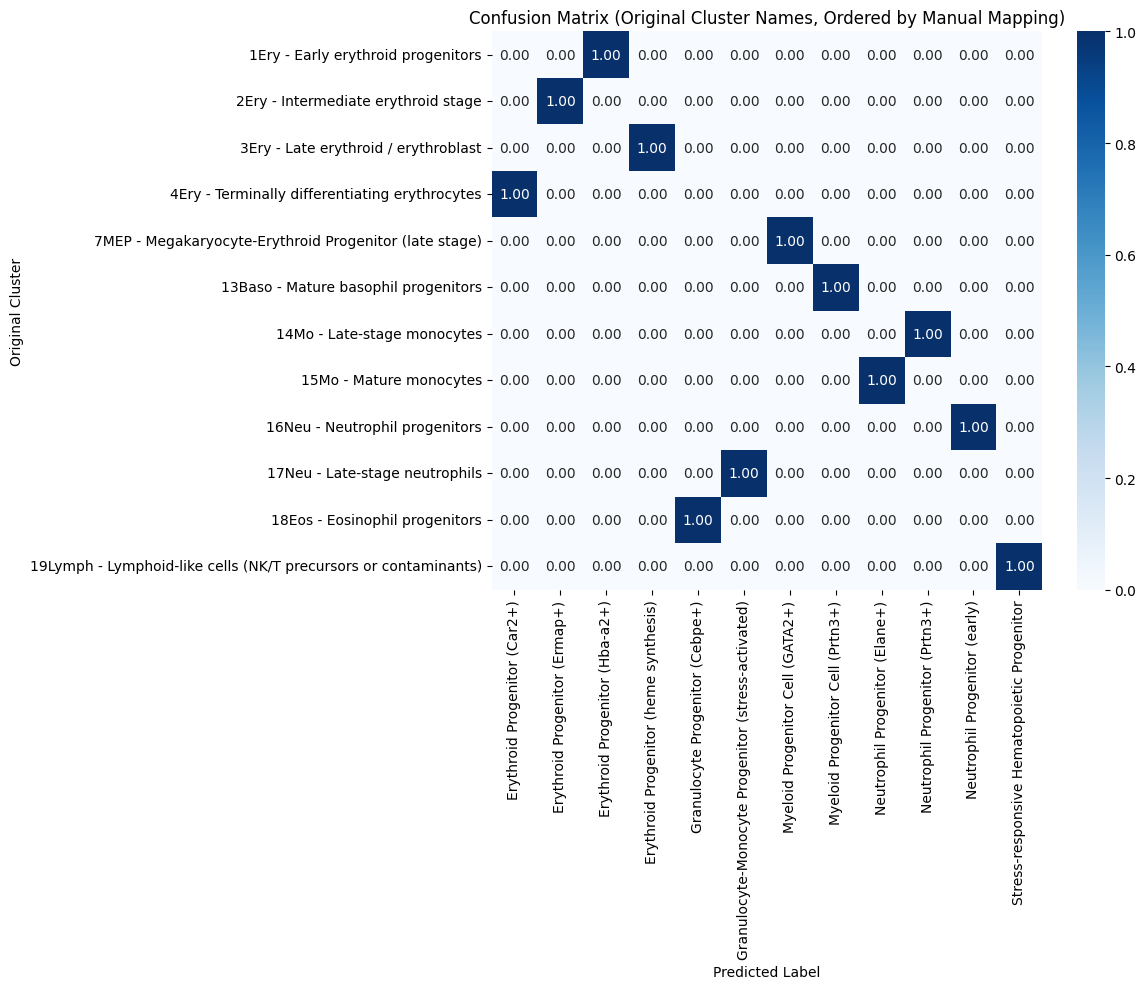

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat_ordered, annot=True, fmt=".2f", cmap="Blues", cbar=True)

plt.title("Confusion Matrix (Original Cluster Names, Ordered by Manual Mapping)")
plt.xlabel("Predicted Label")
plt.ylabel("Original Cluster")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [21]:
adata.obs.groupby(["cytetype_annotation_paul15_clusters", "paul15_clusters"]).size().reset_index().rename(columns={0:'cell_count'}).\
    query("cell_count>0").sort_values("paul15_clusters").drop(columns="cell_count").style.background_gradient(axis=None)               

/tmp/ipykernel_13/3959061399.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(["cytetype_annotation_paul15_clusters", "paul15_clusters"]).size().reset_index().rename(columns={0:'cell_count'}).\


,cytetype_annotation_paul15_clusters,paul15_clusters
76,Erythroid Progenitor (Hba-a2+),1Ery
58,Erythroid Progenitor (Ermap+),2Ery
97,Erythroid Progenitor (heme synthesis),3Ery
41,Erythroid Progenitor (Car2+),4Ery
4,Early Erythroid Progenitor with Megakaryocytic Potential,5Ery
119,Erythroid Progenitor (ribosomal),6Ery
215,Myeloid Progenitor Cell (GATA2+),7MEP
178,Megakaryocyte Progenitor,8Mk
236,Myeloid Progenitor Cell (GPR56+),9GMP
28,Early Myeloid Progenitor,10GMP


In [22]:
adata.obs[["paul15_fullname"]].value_counts()

paul15_fullname                                                
14Mo - Late-stage monocytes                                        373
2Ery - Intermediate erythroid stage                                329
13Baso - Mature basophil progenitors                               300
3Ery - Late erythroid / erythroblast                               246
15Mo - Mature monocytes                                            186
7MEP - Megakaryocyte-Erythroid Progenitor (late stage)             167
16Neu - Neutrophil progenitors                                     164
4Ery - Terminally differentiating erythrocytes                     124
1Ery - Early erythroid progenitors                                  43
19Lymph - Lymphoid-like cells (NK/T precursors or contaminants)     31
17Neu - Late-stage neutrophils                                      22
18Eos - Eosinophil progenitors                                       9
Name: count, dtype: int64

In [23]:
adata.obs[["cytetype_annotation_paul15_clusters", "paul15_fullname"]].value_counts()

cytetype_annotation_paul15_clusters                 paul15_fullname                                                
Neutrophil Progenitor (Prtn3+)                      14Mo - Late-stage monocytes                                        373
Erythroid Progenitor (Ermap+)                       2Ery - Intermediate erythroid stage                                329
Myeloid Progenitor Cell (Prtn3+)                    13Baso - Mature basophil progenitors                               300
Erythroid Progenitor (heme synthesis)               3Ery - Late erythroid / erythroblast                               246
Neutrophil Progenitor (Elane+)                      15Mo - Mature monocytes                                            186
Myeloid Progenitor Cell (GATA2+)                    7MEP - Megakaryocyte-Erythroid Progenitor (late stage)             167
Neutrophil Progenitor (early)                       16Neu - Neutrophil progenitors                                     164
Erythroid Progenitor (C

In [24]:
adata.obs

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,paul15_clusters,leiden,cytetype_annotation_paul15_clusters,cytetype_cellOntologyTerm_paul15_clusters,true_broad,paul15_fullname
W31105,7MEP,6,Myeloid Progenitor Cell (GATA2+),CL_0000839,NaN,7MEP - Megakaryocyte-Erythroid Progenitor (lat...
W31106,15Mo,7,Neutrophil Progenitor (Elane+),CL_0000834,NaN,15Mo - Mature monocytes
W31107,3Ery,1,Erythroid Progenitor (heme synthesis),CL_0000038,NaN,3Ery - Late erythroid / erythroblast
W31108,15Mo,3,Neutrophil Progenitor (Elane+),CL_0000834,NaN,15Mo - Mature monocytes
W31109,3Ery,1,Erythroid Progenitor (heme synthesis),CL_0000038,NaN,3Ery - Late erythroid / erythroblast
...,...,...,...,...,...,...
W39164,2Ery,0,Erythroid Progenitor (Ermap+),CL_0000038,NaN,2Ery - Intermediate erythroid stage
W39165,13Baso,4,Myeloid Progenitor Cell (Prtn3+),CL_0000839,NaN,13Baso - Mature basophil progenitors
W39166,7MEP,6,Myeloid Progenitor Cell (GATA2+),CL_0000839,NaN,7MEP - Megakaryocyte-Erythroid Progenitor (lat...
W39167,15Mo,3,Neutrophil Progenitor (Elane+),CL_0000834,NaN,15Mo - Mature monocytes


In [25]:
#sc.pl.embedding(adata, basis='umap', color='cytetype_annotation_cell_type')

## What if we give the wrong description?

Let's give a wrong instruction to CyteType, for example by saying that this is a retina dataset in Zebrafish, to see if it still returns good results

In [26]:
adata2 = adata.copy()
# Initialize CyteType (performs data preparation)
annotator = cytetype.CyteType(
    adata2,
    group_key='paul15_clusters',
    rank_key='rank_genes_groups',
    gene_symbols_column='gene_symbols',
    n_top_genes=50,
)

Using coordinates from 'X_pca' for visualization.
Calculating expression percentages.
Extracting marker genes.
Preparing visualization data with sampling.
Using first 2 dimensions of 'X_pca' for visualization.
Extracted 2730 coordinate points (sampled from 2730 total cells)
Data preparation completed. Ready for submitting jobs.


In [27]:
adata2 = annotator.run(
    study_context="Zebrafish retina development during embryogenesis"
)


CyteType job (id: e24e9f07-29e2-484c-8b7f-038e95de8b72) submitted. Polling for results...
Report (updates automatically) available at: https://nygen-labs-prod--cytetype-api.modal.run/report/e24e9f07-29e2-484c-8b7f-038e95de8b72
If network disconnects, the results can be fetched like this:
`results = annotator.get_results()`
250717:1357:46 |INFO| [STARTING WORKFLOWS]: Job ID: e24e9f07-29e2-484c-8b7f-038e95de8b72
250717:1357:46 |INFO| [WORKFLOW STEP 1/3]: Generating context summary
250717:1358:00 |INFO| [WORKFLOW STEP 2/3]: Running annotation pipeline for each cluster
250717:1359:07 |SUCCESS| [Cluster: 1] Annotation completed in 43.60s after 1 attempt(s) and 59942 tokens used
250717:1359:17 |SUCCESS| [Cluster: 4] Annotation completed in 51.78s after 1 attempt(s) and 66244 tokens used
250717:1359:29 |SUCCESS| [Cluster: 2] Annotation completed in 66.62s after 1 attempt(s) and 59356 tokens used
250717:1400:23 |SUCCESS| [Cluster: 5] Annotation completed in 117.41s after 2 attempt(s) and 11119

In [28]:
# adata2.obs["true_broad"] = adata2.obs["paul15_clusters"].map(label_map)

# pd.crosstab(adata2.obs["true_broad"], adata2.obs["cytetype_paul15_clusters"], normalize='index')


In [29]:
# adata2.obs["paul15_fullname"] = adata2.obs["paul15_clusters"].map(paul15_label_fullname)


In [30]:
# # Create normalized confusion matrix
# conf_mat = pd.crosstab(
#     adata2.obs["true_broad"],
#     adata2.obs["cytetype_paul15_clusters"],
#     normalize='index'
# )

# # Plot with seaborn
# plt.figure(figsize=(10, 6))
# sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt=".2f", cbar=True)
# plt.title("CyteType vs Paul15 Broad Cell Type Mapping")
# plt.ylabel("True Label (Paul15 Broad)")
# plt.xlabel("Predicted Label (CyteType)")
# plt.tight_layout()
# plt.show()

In [31]:
# # Let's also look at the Confusion matrix with the original cluster names
# conf_mat_original = pd.crosstab(adata2.obs["paul15_clusters"], adata2.obs["cytetype_paul15_clusters"], normalize='index')
# conf_mat_original



# # Step 3: Define full-name order
# manual_order_full = list(paul15_label_fullname.values())


# # Step 4: Create and reorder confusion matrix
# conf_mat_full = pd.crosstab(
#     adata2.obs["paul15_fullname"],
#     adata2.obs["cytetype_paul15_clusters"],
#     normalize='index'
# )
# # Only keep labels that exist in the confusion matrix
# existing_labels = [label for label in manual_order_full if label in conf_mat_full.index]

# # Reorder based on existing labels only
# conf_mat_ordered = conf_mat_full.loc[existing_labels]

# # Optional: reorder columns if matching set
# if all(label in conf_mat_ordered.columns for label in manual_order_full):
#     conf_mat_ordered = conf_mat_ordered[manual_order_full]

In [32]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 10))
# sns.heatmap(conf_mat_ordered, annot=True, fmt=".2f", cmap="Blues", cbar=True)

# plt.title("Confusion Matrix (Original Cluster Names, Ordered by Manual Mapping) - using a wrong study context")
# plt.xlabel("Predicted Label")
# plt.ylabel("Original Cluster")
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()
